<h3 style="color: pink;">PROYECTO 2 ESTADÍSTICA</h3>
<p>Karen Agudelo Toro, c.c. 1036250737</p>
<p>Alejandro Loturco Acevedo, c.c. 1005040605</p>

<h4> Importación librerias</h4>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from statsmodels.sandbox.stats.runs import runstest_1samp 
from statsmodels.formula.api import ols 
import statsmodels.api as sm 
from tabulate import tabulate
from statsmodels.stats.multicomp import pairwise_tukeyhsd

<h4>Funciones</h4>

In [2]:
def informacion(dat,categorico=False):
    """Con el ingreso de una serie de datos, devuelve una lista con la media, 
    mediana, moda, SD, MAD, varianza, IQR, CV y CVM."""
    lista = []    
    if categorico == False:
        # Intentamos tratar los datos como numéricos
        dat = pd.to_numeric(dat)
        lista.append(np.mean(dat))  # media
        lista.append(np.median(dat))  # mediana
        moda = dat.mode().iloc[0] if not dat.mode().empty else np.nan #Si no es categorico calcula la moda
        lista.append(moda)
        lista.append(np.std(dat))  # SD
        lista.append(stats.median_abs_deviation(dat))  # MAD
        lista.append(np.var(dat))  # Varianza
        Q1 = np.percentile(dat, 25)
        Q3 = np.percentile(dat, 75)
        lista.append(Q3 - Q1)  # IQR
        lista.append(dat.std(ddof=1) / dat.mean() * 100)  # CV
        lista.append((stats.median_abs_deviation(dat)/ np.median(dat)) if np.median(dat) != 0 else np.nan)  # CVM
    elif categorico == True:
        lista = [np.nan] * 9  
        lista[2] = dat.mode().iloc[0] if not dat.mode().empty else np.nan  
    
    return lista

def atipicos (valor):  
    """Con el ingreso de una serie de datos, devuelve una lista con los datos 
    atipicos y la cantidad de estos."""  
    atipico = []
    valor = pd.to_numeric(valor)
    Q1 = np.nanpercentile(valor,25)    
    Q3 =np.nanpercentile(valor,75)
    iqr = Q3-Q1

    for x in valor:
        if x < (Q1 - 1.5*iqr) :
            atipico.append(x)
        elif x > (Q3 + 1.5*iqr):
            atipico.append(x)
            
    cont = len(atipico)
    return  cont,atipico

def mostrar_atipicos(lista : list, df):
    """Recibe una lista de variables y un dataframe, y muestra la 
    cantidad de datos atipicos y los datos atipicos para cada variable."""
    for i in range(len(lista)):
        cont,datos = atipicos(df[lista[i]])
        print(f"{lista[i]} tiene {cont} datos atipicos")
        print("Los datos atipicos son:")
        print(datos)
        print("\n")

def extraer_y_promediar(df, indices_dict, nombres_cols):
    """Extrae de un dataframe las columnas especificadas por los índices y nombres 
    de columnas, y devuelve la media de cada fila."""
    columnas = [indices_dict[n] for n in nombres_cols]
    data_temp = df.iloc[:, columnas].copy()
    data_temp.columns = nombres_cols

    for col in nombres_cols:
        data_temp[col] = pd.to_numeric(data_temp[col], errors='coerce')
        data_temp[col] = data_temp[col].fillna(data_temp[col].mean())

    return data_temp.mean(axis=1)

def convertir_numericas(df, variables_numericas):
    """Convierte las columnas especificadas en el dataframe a tipo numérico."""
    for i in variables_numericas:
        df[i] = pd.to_numeric(df[i], errors='coerce')
    return df

def test_normalityKS(datos, variable): # Pruaba de Normalidad Kolmogorov-Smirnof 
    """
    data: arreglo de datos a evaluar la normalidad
    variable: string con el nombre de la variable 
    """  
    print(f"\n Análisis de normalidad por Kolmogorov-Smirnov para '{variable}'")

    # Kolmogorov-Smirnov (KS) test
    ks_stat, ks_p = stats.kstest(datos, 'norm', args=(np.mean(datos), np.std(datos)))
    print(f" Estadístico = {ks_stat:.4f}, p-valor = {ks_p:.4f}")
    return ks_stat, ks_p


<p>Diccionario para almacenar las variables y sus índices (columnas del CSV).<br>
Lista usada para la extraccion de las variables numericas a promediar</p>

In [3]:
cols = {'aveOralM':115,
'Max1R13_1':3,
'Max1R13_2':31,
'Max1R13_3':59,
'Max1R13_4': 87,
'Max1L13_1':5,
'Max1L13_2':33,
'Max1L13_3':61,
'Max1L13_4':89,
'T_Max_1': 27,
'T_Max_2': 55,
'T_Max_3': 83,
'T_Max_4': 111,
'TF_HCC_1': 20,
'TF_HCC_2': 48,
'TF_HCC_3': 76,
'TF_HCC_4': 104
}

variables_numericas = [
    'aveOralM',  
    'PromMax1R13',
    'PromMax1L13',
    'PromT_Max',
    'PromTF_HCC'
]

<h3><strong>Punto 1</strong></h3>
<p>Se realiza la lectura de la base de datos junto con el tratamiento adecuado de los datos. <br><br>
La variable <strong>aveOralM</strong> se extrae directamente y se incorpora al diccionario. <br><br>
Por otro lado, las variables que deben promediarse (<em>Max1R13, Max1L13, T_Max, TF_HCC</em>) se obtienen mediante una función que ejecuta iteraciones en función de la variable indicada.<br><br>
Una vez extraídas, se calculan sus promedios y también se agregan al diccionario.<br><br>
Luego de recolectar toda la información relevante, se construye el diccionario resultados utilizando una función que calcula los estadísticos solicitados.<br>
Finalmente, el diccionario se convierte en un <em>DataFrame</em>.</p>


In [4]:
csv = pd.read_csv(r'FLIR_groups1and2.csv', delimiter=';')
csv = csv.iloc[2:].reset_index(drop=True)
 
columnas = ['aveOralM']
indices = [cols[col] for col in columnas]


csv_filter = csv.iloc[:, indices].copy()
csv_filter.columns = columnas

csv_filter.loc[:, 'PromMax1R13'] = extraer_y_promediar(csv, cols, ['Max1R13_1','Max1R13_2','Max1R13_3','Max1R13_4'])
csv_filter.loc[:, 'PromMax1L13'] = extraer_y_promediar(csv, cols, ['Max1L13_1','Max1L13_2','Max1L13_3','Max1L13_4'])
csv_filter.loc[:, 'PromT_Max'] = extraer_y_promediar(csv, cols, ['T_Max_1','T_Max_2','T_Max_3','T_Max_4'])
csv_filter.loc[:, 'PromTF_HCC'] = extraer_y_promediar(csv, cols, ['TF_HCC_1','TF_HCC_2','TF_HCC_3','TF_HCC_4'])

convertir_numericas(csv_filter, variables_numericas)

resultados = {'': ["Media", "Mediana", "Moda", "SD", "MAD", "Varianza", "IQR", "CV", "CVM"],    
    'aveOralM': informacion(csv_filter['aveOralM']),
    'PromMax1R13': informacion(csv_filter['PromMax1R13']),
    'PromMax1L13': informacion(csv_filter['PromMax1L13']),	
    'PromT_Max': informacion(csv_filter['PromT_Max']),
    'PromTF_HCC': informacion(csv_filter['PromTF_HCC'])
}

df_estadisticas = pd.DataFrame(resultados)
csv_filter.to_csv('FLIR_groups1and2_replace.csv',  sep=';', decimal=',',index=False)

Visualizacion del dataframe creado con los estadisticos creados

In [5]:
print("Resumen estadístico completo:\n")
print(df_estadisticas)

Resumen estadístico completo:

              aveOralM  PromMax1R13  PromMax1L13  PromT_Max  PromTF_HCC
0     Media  37.028382    35.597916    34.889475  35.809334   34.567550
1   Mediana  36.940000    35.550000    34.916250  35.798750   34.597500
2      Moda  36.890000    35.677500    35.175000  36.032500   35.002500
3        SD   0.509252     0.564823     0.708276   0.547745    0.658736
4       MAD   0.200000     0.302500     0.398750   0.308750    0.381250
5  Varianza   0.259338     0.319025     0.501655   0.300024    0.433933
6       IQR   0.362500     0.603750     0.808129   0.603125    0.759479
7        CV   1.375978     1.587452     2.031052   1.530364    1.906583
8       CVM   0.005414     0.008509     0.011420   0.008625    0.011020


<h4><strong>Comparación SD Y MAD</strong></h4>


<h5 style="color: pink;">aveOralM</h5>
<p><strong>SD</strong>: 0.509252 <br>
<strong>MAD</strong>:  0.200000 

$\frac{0.2}{0.51} = 0.4$<br>
1 - 0.4 = 0.6 ----> 60%<br></p>
Esta relación es la mayor de todas, lo cual sugiere la presencia de datos atípicos y alta dispersión de esta categoría

<h5 style="color: pink;">PromMax1R13</h5>
<p><strong>SD</strong>: 0.564823  <br>
<strong>MAD</strong>:  0.302500 

$\frac{0.3}{0.5} = 0.6$<br><br>
1 - 0.6 = 0.4 ----> 40% <br></p>

<h5 style="color: pink;">PromMax1L13</h5>
<p><strong>SD</strong>: 0.708276   <br>
<strong>MAD</strong>:  0.398750 

$\frac{0.4}{0.7} = 0.57$<br><br>
1 - 0.57 = 0.43 ----> 43% <br></p>

<h5 style="color: pink;">PromT_Max </h5>
<p><strong>SD</strong>: 0.547745   <br>
<strong>MAD</strong>:  0.308750 

$\frac{0.31}{0.5} = 0.62$<br><br>
1 - 0.62 = 0.38 ----> 38% <br></p>

<h5 style="color: pink;">PromTF_HCC</h5>
<p><strong>SD</strong>: 0.658736   <br>
<strong>MAD</strong>:  0.381250

$\frac{0.4}{0.6} = 0.66$<br><br>
1 - 0.66 = 0.34 ----> 34% <br></p>
Esta relación es la menor de todas, lo cual sugiere una distribución bastante simétrica de los datos y la no presencia de datos atípicos. 
</p>

<h3><strong>Datos atípicos</strong></h3>

In [ ]:
print(variables_numericas)
print(csv_filter)
mostrar_atipicos(variables_numericas, csv_filter)

Antes de realizar la prueba T para muestras pareadas, debemos verificar la normalidad de la distribución de las diferencias.

In [ ]:
def transformar_y_analizar(df, columnas, test_func):
    """
    Para cada columna en `columnas`, crea una nueva columna con sufijo '_filter'
    donde se resta la mediana, aplica una prueba de normalidad y muestra los atípicos.
    Parámetros:
    - df: DataFrame original
    - columnas: lista de nombres de columnas numéricas
    - test_func: función que aplica la prueba de normalidad (ej. test_normalityKS)
    """
    for col in columnas:
        med = df[col].median()
        col_nueva = f'{col}_filter'
        df[col_nueva] = df([col] - med)
        datos_trasnformados, lambda_ = stats.boxcox(df[col_nueva])
        print(f"\nResultados para la variable transformada: {col_nueva}")
        _, _ = test_func(df[col_nueva], col_nueva)
        return datos_trasnformados, lambda_
        


In [ ]:
med = csv_filter['aveOralM'].median()  # Use the median as a scalar value
lista_prueba = []
for i in csv_filter['aveOralM']:
    lista_prueba.append((i - med))  # Subtract the scalar median from each value
    
csv_filter['aveOralM_filter'] = lista_prueba

_, _ = test_normalityKS(csv_filter['aveOralM_filter'], 'aveOralM_filter')

mostrar_atipicos(['aveOralM_filter'], csv_filter)

In [ ]:
variables_a_filtrar = ['aveOralM','PromMax1R13', 'PromMax1L13', 'PromT_Max', 'PromTF_HCC']
transformar_y_analizar(csv_filter, variables_a_filtrar, test_normalityKS)

<p><strong>Función para verificar la normalidad de la distribución de las frecuencias</strong><br>

<h4><strong>Histograma</strong></h4>


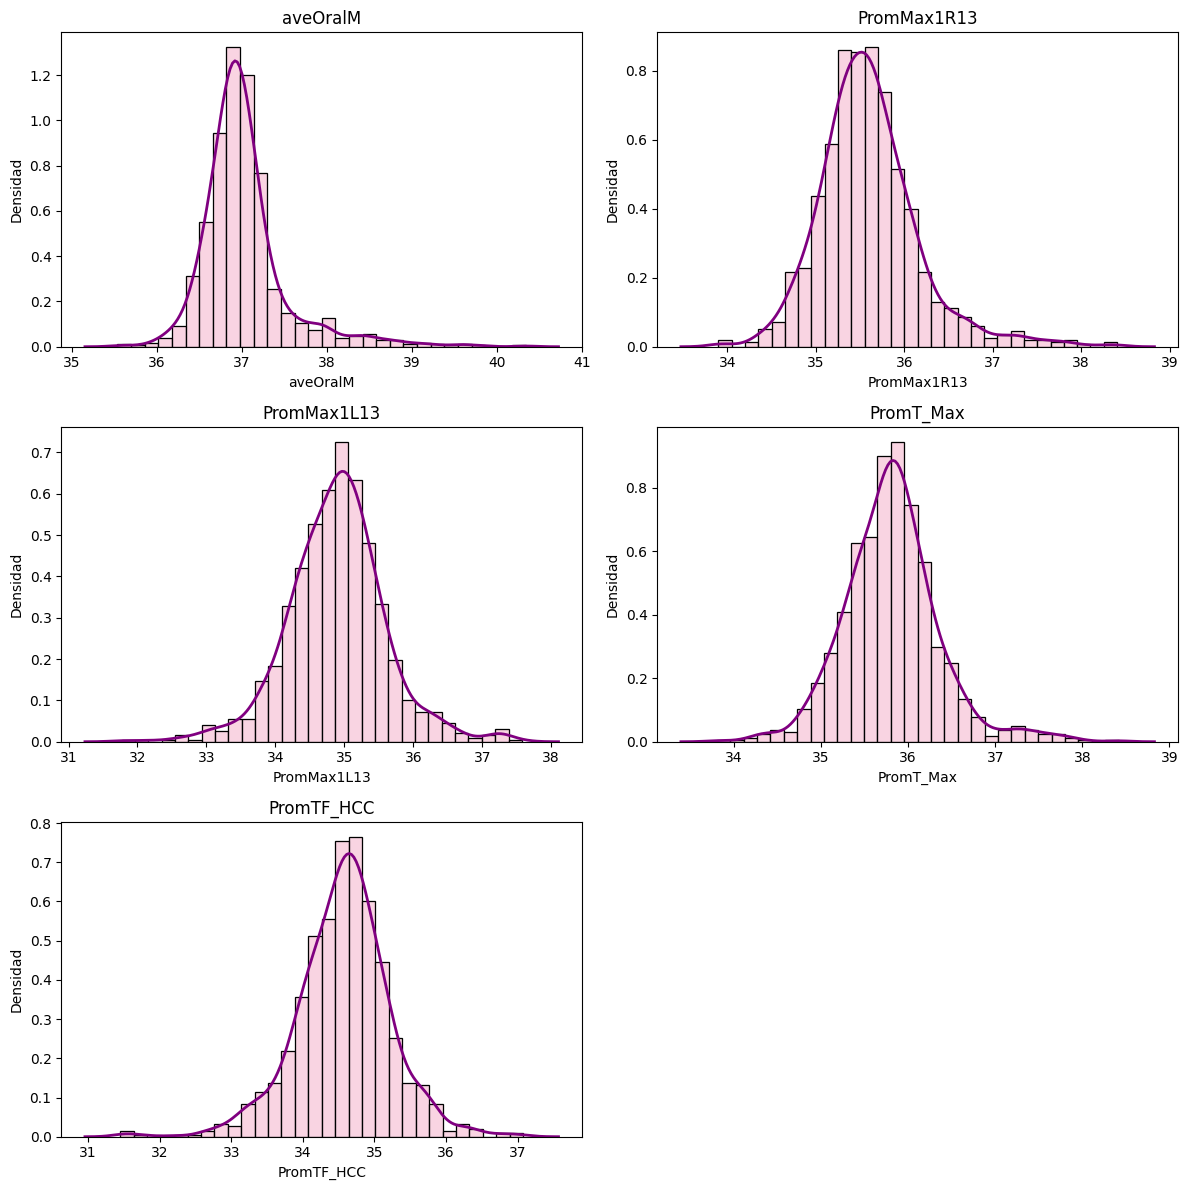

In [38]:
plt.figure(figsize=(12, 12))
for i, col in enumerate(variables_numericas):
    plt.subplot(3, 2, i + 1)  # Adjusted to a 3x2 grid
    sns.histplot(csv_filter[col], bins=30, color="#F7C6D9", stat="density")
    sns.kdeplot(csv_filter[col], color="purple", linewidth=2)
    plt.title(f"{col}")
    plt.ylabel("Densidad")
plt.tight_layout()
plt.show()

<p><strong>Histograma aveOralM</strong><br>
<p>Se observa una alta concentración de datos pero no hay una simetría perfecta, hay una distribución asimétrica a la derecha. Por lo tanto, no parece completamente normal<p><br>
<p><strong>Histograma PromMax1R</strong><br>




<h4><strong>Boxplots</strong></h4>

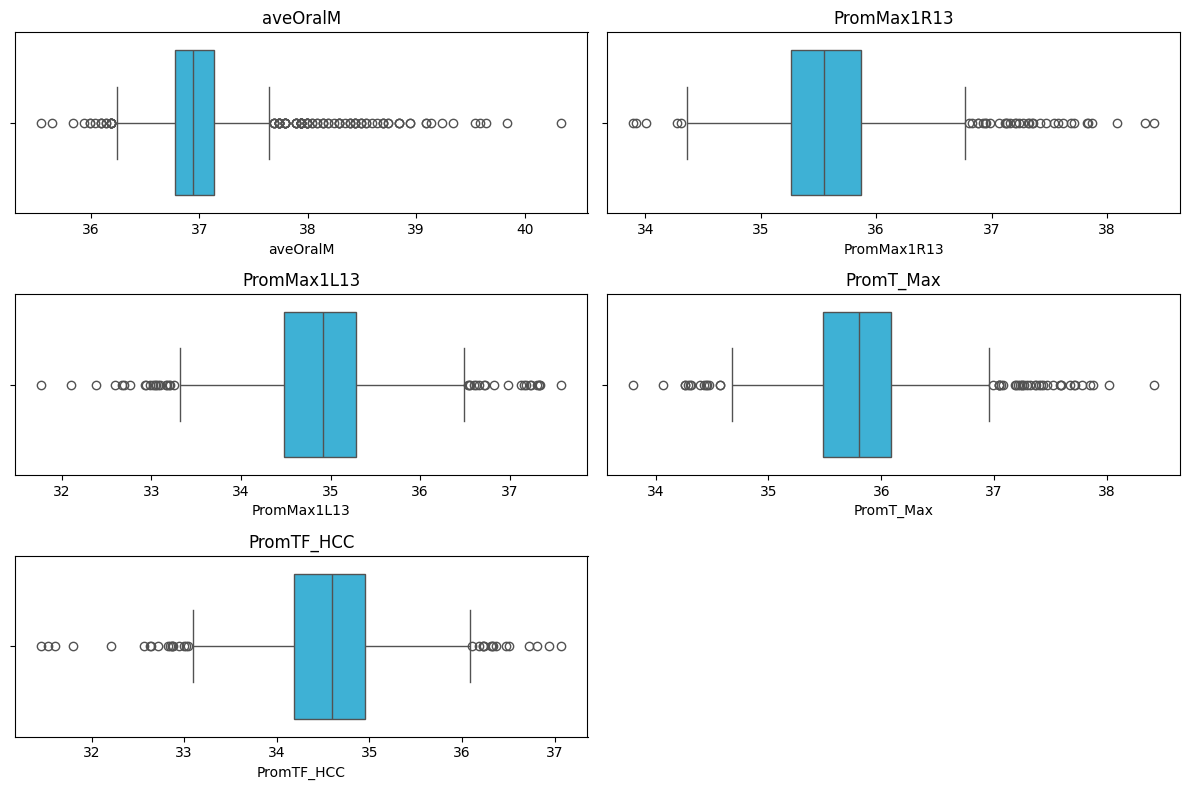

In [40]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(variables_numericas):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x=csv_filter[col], color="#25beee")
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

<h4><strong>Matriz de correlación</strong></h4>

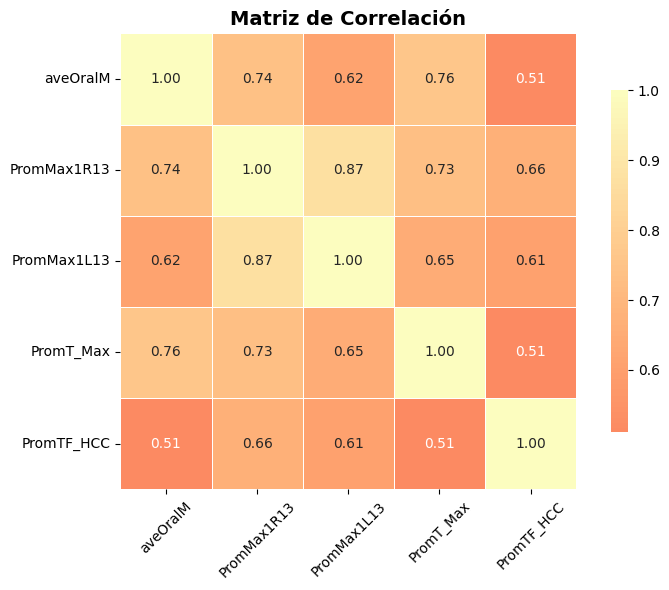

In [41]:
matrix = csv_filter[variables_numericas].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    matrix,
    annot=True,
    fmt=".2f",
    cmap='magma',      
    center=0,
    linewidths=0.5,
    linecolor='white',
    square=True,
    cbar_kws={"shrink": .75})
plt.title("Matriz de Correlación", fontsize=14, weight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<h4><strong>Datos atípicos</strong></h4>

In [ ]:
med = csv_filter['aveOralM'].median()  # Use the median as a scalar value
lista_prueba = []
for i in csv_filter['aveOralM']:
    lista_prueba.append((i - med))  # Subtract the scalar median from each value
    
csv_filter['aveOralM_filter'] = lista_prueba

_, _ = test_normalityKS(csv_filter['aveOralM_filter'], 'aveOralM_filter')

mostrar_atipicos(['aveOralM_filter'], csv_filter)

<h4><strong>Punto 2</strong></h4>

1. Analisis exploratorio

In [17]:
df_a375 = pd.read_excel("A375.xlsx")

resultados = {'': ["Media", "Mediana", "Moda", "SD", "MAD", "Varianza", "IQR", "CV", "CVM"],    
    'Bloque2': informacion(df_a375['Bloque2']),
    'Estimulo2': informacion(df_a375['Estimulo2']),
    'Tiempo2': informacion(df_a375['Tiempo2']),	
    'Viabilidad2': informacion(df_a375['Viabilidad2'])
}

df_estadisticas = pd.DataFrame(resultados)
print("Resumen estadístico completo:\n")
print(df_estadisticas)

Resumen estadístico completo:

               Bloque2  Estimulo2    Tiempo2  Viabilidad2
0     Media   3.416667   1.500000   3.500000   101.884495
1   Mediana   3.000000   1.500000   1.000000    98.611111
2      Moda   3.000000   1.000000   1.000000    80.171885
3        SD   0.493007   0.500000   2.958040    23.056690
4       MAD   0.000000   0.500000   0.000000    18.055556
5  Varianza   0.243056   0.250000   8.750000   531.610947
6       IQR   1.000000   1.000000   6.000000    31.386896
7        CV  14.739809  34.050261  86.333169    23.116952
8       CVM   0.000000   0.333333   0.000000     0.183099


Atipicos

In [ ]:
variables_numericas_a375 = ['Bloque2', 'Estimulo2', 'Tiempo2', 'Viabilidad2']
mostrar_atipicos(variables_numericas_a375, df_a375)


Bloque2 tiene 0 datos atipicos
Los datos atipicos son:
[]


Estimulo2 tiene 0 datos atipicos
Los datos atipicos son:
[]


Tiempo2 tiene 0 datos atipicos
Los datos atipicos son:
[]


Viabilidad2 tiene 0 datos atipicos
Los datos atipicos son:
[]




<h4><strong>Histograma</strong></h4>

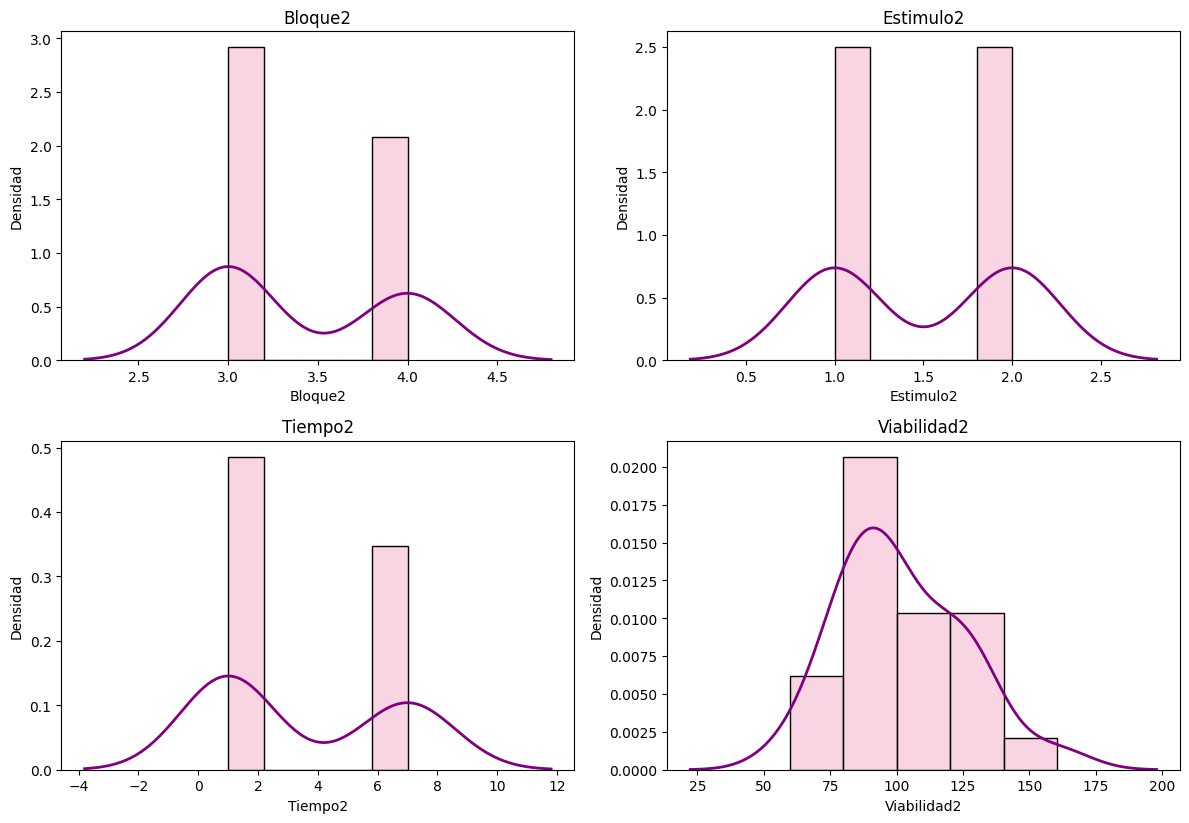

In [21]:
plt.figure(figsize=(12, 12))
for i, col in enumerate(variables_numericas_a375):
    plt.subplot(3, 2, i + 1)  # Adjusted to a 3x2 grid
    sns.histplot(df_a375[col], bins=5, color="#F7C6D9", stat="density")
    sns.kdeplot(df_a375[col], color="purple", linewidth=2)
    plt.title(f"{col}")
    plt.ylabel("Densidad")
plt.tight_layout()
plt.show()

<h4><strong>Boxplots</strong></h4>

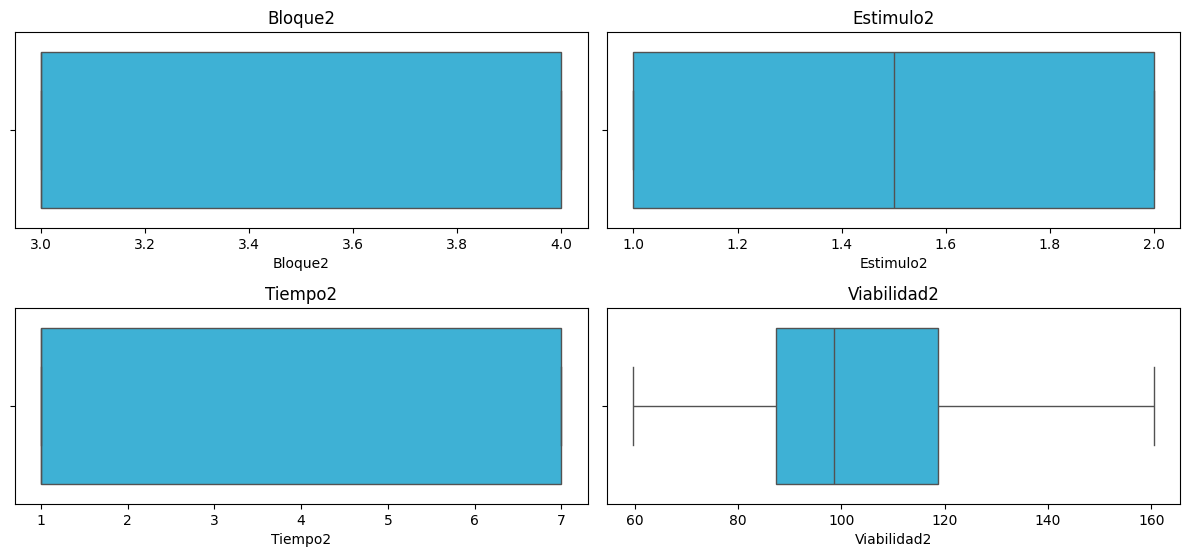

In [22]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(variables_numericas_a375):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x=df_a375[col], color="#25beee")
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

<h4><strong>Matriz de correlación</strong></h4>

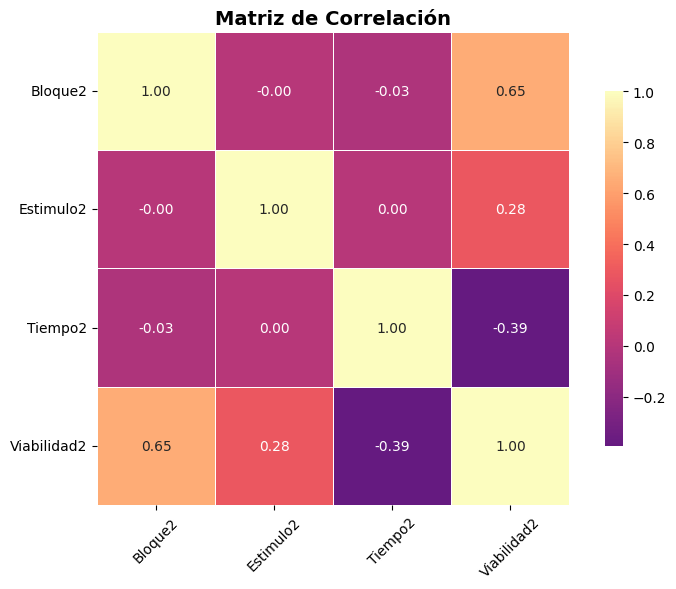

In [24]:
matrix = df_a375[variables_numericas_a375].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    matrix,
    annot=True,
    fmt=".2f",
    cmap='magma',      
    center=0,
    linewidths=0.5,
    linecolor='white',
    square=True,
    cbar_kws={"shrink": .75})
plt.title("Matriz de Correlación", fontsize=14, weight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<p><strong>Validación supuestos del ANOVA</strong><br>

In [26]:
def test_normalitySW(data, variable): # Prueba de Normalizas Shapiro-Wilks 
    """
    data: arreglo de datos a evaluar la normalidad
    variable: string con el nombre de la variable 
    """
    print(f"\nAnálisis de normalidad por Shapiro-Wilk para '{variable}'")
    # Shapiro-Wilk test
    shapiro_stat, shapiro_p = stats.shapiro(data)
    print(f"Estadístico = {shapiro_stat:.4f}, p-valor = {shapiro_p:.4f}")

def t_test_one(data,mu,variable): #Prueba T para una muestra
    """
    data: arreglo de datos a comparar
    mu: media poblacional o valor de referencia 
    variable: string con el nombre de la variable que se está comparando
    """
    print(f"Prueba T para una sola muestra para {variable}")
    t_stat, p_value = stats.ttest_1samp(data, mu)
    print(f"Estadístico = {t_stat:.4f}, valor_p = {p_value:.4f}")

def random_test(residuos):
    """
    Parameters
    ----------
    residuos : Array
        DESCRIPTION: Residuos del ANOVA 
    Returns
    -------
    None.
    """
    _, p_runs = runstest_1samp(residuos, correction=True)
    print(f"Prueba de Runs: p-valor={p_runs}")

def tukey(respuesta,factor, alfa,n_factor):
    """
    Parameters
    ----------
    respuesta : Array
        DESCRIPTION. Array con los datos de la variable respuesta
    factor : Array
        DESCRIPTION.Array con los niveles del factor 
    alfa : Float
        DESCRIPTION. Valor alfa de comparación 
    n_factor : String
        DESCRIPTION. Nombre del factor

    Returns
    -------
    None.
    """    
    tukey = pairwise_tukeyhsd(respuesta, factor, alpha=alfa)
    print(f"Prueba Tukey para el factor {n_factor}")
    print(tukey)

<p><strong>Normalidad</strong><br>

In [27]:
test_normalitySW(df_a375['Viabilidad2'], 'Viabilidad2')


Análisis de normalidad por Shapiro-Wilk para 'Viabilidad2'
Estadístico = 0.9614, p-valor = 0.4675


H0: Los datos provienen de una distribucion normal <br>
H1: Los datos no provienen de una distribucion normal <br>
Se realiza la prueba de normalidad Shapiro-Wilks, en donde el valor p obtenido es mayor al valor alfa (0.05), de esta forma se acepta H0 que indica que los valores de viabilidad (variable de respuesta) son normales.

<p><strong>Homocedasticidad</strong><br>

In [30]:
print("\nValidacion de homecedasticidad para Bloque2 por niveles")
nivel1=df_a375[df_a375['Bloque2']==3]['Viabilidad2']
nivel2=df_a375[df_a375['Bloque2']==4]['Viabilidad2']
_, levene_p = stats.levene(nivel1,nivel2)
print(f"Levene test: p-valor = {levene_p:.4f}")
if levene_p > 0.05:
    print("✔ No se rechaza H0: Homocedasticidad (varianzas iguales entre los grupos).")
else:
    print("✘ Se rechaza H0: Heterocedasticidad (las varianzas son distintas entre los grupos).")


print("\nValidacion de homecedasticidad para Estimulo2 por niveles")
nivel1=df_a375[df_a375['Estimulo2']==1]['Viabilidad2']
nivel2=df_a375[df_a375['Estimulo2']==2]['Viabilidad2']
_, levene_p = stats.levene(nivel1,nivel2)
print(f"Levene test: p-valor = {levene_p:.4f}")
if levene_p > 0.05:
    print("✔ No se rechaza H0: Homocedasticidad (varianzas iguales entre los grupos).")
else:
    print("✘ Se rechaza H0: Heterocedasticidad (las varianzas son distintas entre los grupos).")


print("\nValidacion de homecedasticidad para Tiempo2 por niveles")
nivel1=df_a375[df_a375['Tiempo2']==1]['Viabilidad2']
nivel2=df_a375[df_a375['Tiempo2']==7]['Viabilidad2']
_, levene_p = stats.levene(nivel1,nivel2)
print(f"Levene test: p-valor = {levene_p:.4f}")
if levene_p > 0.05:
    print("✔ No se rechaza H0: Homocedasticidad (varianzas iguales entre los grupos).")
else:
    print("✘ Se rechaza H0: Heterocedasticidad (las varianzas son distintas entre los grupos).")



Validacion de homecedasticidad para Bloque2 por niveles
Levene test: p-valor = 0.4728
✔ No se rechaza H0: Homocedasticidad (varianzas iguales entre los grupos).

Validacion de homecedasticidad para Estimulo2 por niveles
Levene test: p-valor = 0.3440
✔ No se rechaza H0: Homocedasticidad (varianzas iguales entre los grupos).

Validacion de homecedasticidad para Tiempo2 por niveles
Levene test: p-valor = 0.1753
✔ No se rechaza H0: Homocedasticidad (varianzas iguales entre los grupos).


<p><strong>Independencia</strong><br>: falta justifiqueision

<p><strong>Modelo ANOVA</strong><br>

Se usa la llave 'Viabilidad2 ~ C(Bloque2)*C(Estimulo2)*C(Tiempo2)'  para la creación del modelo, donde se consideran como factores el recubrimiento de la nanopartícula, el tiempo de exposición y el tipo de estímulo. Esta fórmula permite incluir tanto los efectos principales como la interacción entre ambos factores, lo que da lugar a un modelo adecuado para el análisis ANOVA.

In [31]:
modelo = ols('Viabilidad2 ~ C(Bloque2)*C(Estimulo2)*C(Tiempo2)', data=df_a375).fit()
anova_table = sm.stats.anova_lm(modelo, typ=3)
print(tabulate(anova_table,headers='keys',tablefmt='heavy_grid'))

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃                                    ┃       sum_sq ┃   df ┃           F ┃       PR(>F) ┃
┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━┫
┃ Intercept                          ┃ 34954.4      ┃    1 ┃ 131.887     ┃   3.8779e-09 ┃
┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━┫
┃ C(Bloque2)                         ┃  1001.32     ┃    1 ┃   3.7781    ┃   0.0697302  ┃
┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━┫
┃ C(Estimulo2)                       ┃    45.8235   ┃    1 ┃   0.172898  ┃   0.683073   ┃
┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━┫
┃ C(Tiempo2)                         ┃   693.645    ┃    1 ┃   2.61721   ┃   0.125252   ┃
┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━┫
┃ C(Bloque